In [1]:
import pandas as pd
import numpy as np

from Bio import SeqIO, SeqUtils
from Bio import SeqIO, SeqUtils
from Bio.SeqUtils import ProtParamData
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# helper libraries
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


# Sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA

# Classsifiers

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

## 1. Data preprocessing

In [2]:
#Load fasta sequence data
cyto = 'dataset/cyto.fasta.txt'
secreted = 'dataset/secreted.fasta.txt'
mito = 'dataset/mito.fasta.txt'
nucleus = 'dataset/nucleus.fasta.txt'
other = 'dataset/other.fasta.txt'
blind = 'dataset/blind.fasta.txt'

with open(cyto) as file:  
    c_idx = []
    c_seq = []
    for seq_record in SeqIO.parse(file, 'fasta'):  
        c_idx.append(seq_record.id)
        c_seq.append(seq_record.seq)

with open(secreted) as file:  
    s_idx = []
    s_seq = []
    for seq_record in SeqIO.parse(file, 'fasta'):  
        s_idx.append(seq_record.id)
        s_seq.append(seq_record.seq)

with open(mito) as file:  
    m_idx = []
    m_seq = []
    for seq_record in SeqIO.parse(file, 'fasta'):  
        m_idx.append(seq_record.id)
        m_seq.append(seq_record.seq)

with open(nucleus) as file:  
    n_idx = []
    n_seq = []
    for seq_record in SeqIO.parse(file, 'fasta'):  
        n_idx.append(seq_record.id)
        n_seq.append(seq_record.seq)

with open(other) as file:  
    o_idx = []
    o_seq = []
    for seq_record in SeqIO.parse(file, 'fasta'):  
        o_idx.append(seq_record.id)
        o_seq.append(seq_record.seq)

with open(blind) as file:  
    b_idx = []
    b_seq = []
    for seq_record in SeqIO.parse(file, 'fasta'):  
        b_idx.append(seq_record.id)
        b_seq.append(seq_record.seq)


# storing all list to dataframes
cyto_df = pd.DataFrame.from_records(c_seq)
cyto_df.fillna(value=np.nan, inplace=True)

sec_df = pd.DataFrame.from_records(s_seq)
sec_df.fillna(value=np.nan, inplace=True)

mito_df = pd.DataFrame.from_records(m_seq)
mito_df.fillna(value=np.nan, inplace=True)

nuc_df = pd.DataFrame.from_records(n_seq)
nuc_df.fillna(value=np.nan, inplace=True)

other_df = pd.DataFrame.from_records(o_seq)
other_df.fillna(value=np.nan, inplace=True)

blind_df = pd.DataFrame.from_records(b_seq)
blind_df.fillna(value=np.nan, inplace=True)


features_df = pd.concat([cyto_df,sec_df, mito_df,nuc_df, other_df, blind_df],0,ignore_index=True)

print('Size of features dataframe: ', features_df.shape)

labels = []
labels = ['cyto'] * len(c_seq)
labels += ['sec'] * len(s_seq)
labels += ['mito'] * len(m_seq)
labels += ['nuc'] * len(n_seq)
labels += ['other'] * len(o_seq)

y = pd.Series(labels)

print('Size of labels: ',len(y))

y.to_pickle('y.pkl') 
print('Storing features dataframe...')

Size of features dataframe:  (11244, 13100)


## 2. Feature Engineering

* 1) Seq length - 1
* 2) Global amino acid count - 20
* 3) First 50 amino acid count - 20
* 4) Last 50 amino acid count - 20
* 5) Isoelectric point - 1
* 6) Aromaticity - 1
* 7) Sec struct - 3 (Calculate fraction of helix, turn and sheet. Returns a list of the fraction of amino acids which tend to * be in Helix, Turn or Sheet.)
* 8) Gravy - 1
* 9) Instability index - 1
* 10) Mol_weights - 1
* 11) Flexibility - 1
* 12) Scales : Hydrophobicity scale - 1. hydrophilicity scale - 1. surface scale - 1
* 13) pH_charge - 1
* 14) mol_coeff - 1

Total # of features = 1 + 20 + 20 + 20 + 1 + 1 + 3 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 = 76

In [18]:
sequences = c_seq + s_seq + m_seq + n_seq + o_seq + b_seq

# Feature 1 - Sequence length
num_of_nulls = features_df.isnull().sum(axis=1)
seq_length = features_df.shape[1] - num_of_nulls

print('Seq length size: ',len(seq_length))
print('Sequence length feature extracted...')

Seq length size:  11244
Sequence length feature extracted...


In [62]:
# Feature 2 - All other features

global_count = {}
local_count_f = {}
local_count_l = {}
iso_point = {}
mol_weights = {}
seq_aroma = {}
inst_idx = {}
flex = {}
sec_struct = {}
hydrophob = {}
hydrophil = {}
surface = {}
mol_coeff = {}
gravy = {}
pH_charge = {}

#feature_df.shape[0]
for i in range(features_df.shape[0]):
    full_seq = ProteinAnalysis(str(sequences[i]))
    global_count[i] = full_seq.count_amino_acids()
    local_count_f[i] = ProteinAnalysis(str(sequences[i])[:50]).count_amino_acids()
    local_count_l[i] = ProteinAnalysis(str(sequences[i])[-50:]).count_amino_acids()
    sec_struct[i] = full_seq.secondary_structure_fraction()

    try:
        iso_point[i] = full_seq.isoelectric_point()
        seq_aroma[i] = full_seq.aromaticity()
        gravy[i] = full_seq.gravy()
        inst_idx[i] = full_seq.instability_index()
        mol_weights[i] = full_seq.molecular_weight()
        flex[i] = np.mean(full_seq.flexibility())
        hydrophob[i] = np.mean(full_seq.protein_scale(ProtParamData.kd, 9, 0.4))
        hydrophil[i] = np.mean(full_seq.protein_scale(ProtParamData.hw, 9, 0.4))
        surface[i] = np.mean(full_seq.protein_scale(ProtParamData.em, 9, 0.4))
        pH_charge[i] = full_seq.charge_at_pH(7.0)
        mol_coeff[i] = full_seq.molar_extinction_coefficient()
    except (KeyError,ValueError):
        iso_point[i] = (0)
        seq_aroma[i] = (0)
        gravy[i] = (0)
        mol_weights[i] = (0)
        inst_idx[i] = (0)
        flex[i] = (0)
        hydrophob[i] = (0)
        hydrophil[i] = (0)
        surface[i] = (0)
        pH_charge[i] = (0)
        mol_coeff[i] = (0,0)
    if i == 3:
        mol_coeff[i] = (0,0)

print('Biopython features extracted...')

Biopython features extracted...


In [71]:

gb_c = pd.DataFrame(global_count).T
gb_c.columns = ['A_gb', 'C_gb', 'D_gb', 'E_gb', 'F_gb', 'G_gb', 'H_gb', 'I_gb', 'K_gb', 'L_gb', 'M_gb', 'N_gb', 'P_gb', 'Q_gb', 'R_gb', 'S_gb', 'T_gb', 'V_gb', 'W_gb', 'Y_gb']
l_cf = pd.DataFrame(local_count_f).T
l_cf.columns = ['A_loc_f', 'C_loc_f',
               'D_loc_f',
               'E_loc_f',
               'F_loc_f',
               'G_loc_f',
               'H_loc_f',
               'I_loc_f',
               'K_loc_f', 'L_loc_f', 'M_loc_f', 'N_loc_f',
               'P_loc_f',
               'Q_loc_f',
               'R_loc_f',
               'S_loc_f', 'T_loc_f', 'V_loc_f', 'W_loc_f', 'Y_loc_f']
l_cl = pd.DataFrame(local_count_l).T
l_cl.columns = [
               'A_loc_l', 
               'C_loc_l',
               'D_loc_l',
               'E_loc_l',
               'F_loc_l',
               'G_loc_l',
               'H_loc_l',
               'I_loc_l',
               'K_loc_l', 'L_loc_l', 'M_loc_l', 'N_loc_l',
               'P_loc_l',
               'Q_loc_l',
               'R_loc_l',
               'S_loc_l', 'T_loc_l', 'V_loc_l', 'W_loc_l', 'Y_loc_l']

iso_c = pd.DataFrame(iso_point.values(),columns=['iso_point'])
mlw_c = pd.DataFrame(mol_weights.values(),columns=['mol_weights'])
aroma_c = pd.DataFrame(seq_aroma.values(),columns=['aroma'])
sec_c = pd.DataFrame(sec_struct).T
sec_c.columns = ['helix','turn','sheet']
g_c = pd.DataFrame(gravy.values(),columns=['gravy'])
i_c = pd.DataFrame(inst_idx.values(),columns=['ins_indx'])
f_c = pd.DataFrame(flex.values(),columns=['flexibility'])
hydrophob_df = pd.DataFrame(hydrophob.values(), columns=['hydrophob'])
hydrophil_df = pd.DataFrame(hydrophil.values(), columns=['hydrophil'])
surface_df = pd.DataFrame(surface.values(), columns=['surface'])
ph_df = pd.DataFrame(pH_charge.values(), columns=['ph'])
mol_coeff_df = pd.DataFrame(mol_coeff).T
mol_coeff_df.columns = ['mec_reduced','mec_cystines']


X = pd.concat([gb_c, l_cf, l_cl, iso_c, mlw_c, aroma_c, sec_c,g_c,i_c,f_c,hydrophob_df,hydrophil_df,surface_df, ph_df, mol_coeff_df],1)
print(X.shape)

X['seq_length'] = seq_length.values

print('Total no. of features: ',X.shape[1])

# saving the features dataframe 

X.to_pickle('X.pkl') 
print('Storing features dataframe...')


(11244, 75)
Total no. of features:  76
Storing features dataframe...


### 3. Feature Selection

In [81]:
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')
X_blind = X.iloc[-20:,:]
X = X.iloc[:-20,:]
X.shape, y.shape, X_blind.shape

((11224, 76), (11224,), (20, 76))

#### 3.1) Correlation Matrix

Text(32.09375, 0.5, 'Features')

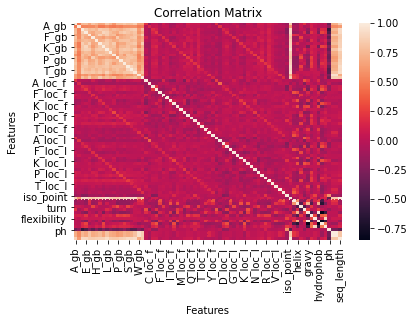

In [82]:
df_corr = pd.DataFrame(X)
le = LabelEncoder()
le.fit(y)
y_corr = le.transform(y)
# df_corr['target'] = pd.Series(y_corr, index=df_corr.index)

# plt.figure(figsize=(19, 15))
corr_matrix = df_corr.corr()
sns.heatmap(corr_matrix)
plt.title('Correlation Matrix')
plt.xlabel('Features')
plt.ylabel('Features')

In [83]:
X.shape

(11224, 76)

In [67]:
idx = abs(corr_matrix['target']).nlargest(15).index
print(idx)
print(abs(corr_matrix['target']).nlargest(15))

Index(['target', 'E_gb', 'K_gb', 'M_gb', 'L_gb', 'surface', 'R_gb',
       'mol_weights', 'hydrophil', 'S_gb', 'seq_length', 'ins_indx', 'H_gb',
       'Q_gb', 'gravy'],
      dtype='object')
target         1.000000
E_gb           0.253862
K_gb           0.251470
M_gb           0.227451
L_gb           0.224845
surface        0.217435
R_gb           0.216681
mol_weights    0.215270
hydrophil      0.215053
S_gb           0.210166
seq_length     0.208694
ins_indx       0.206639
H_gb           0.205247
Q_gb           0.202443
gravy          0.201489
Name: target, dtype: float64


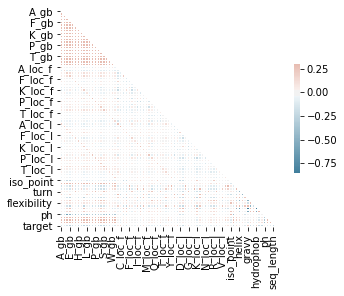

In [270]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(25, 20))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [84]:
y.shape, corr_matrix['seq_length'].shape

((11224,), (76,))

In [85]:
corr_matrix

,A_gb,C_gb,D_gb,E_gb,F_gb,G_gb,H_gb,I_gb,K_gb,L_gb,...,gravy,ins_indx,flexibility,hydrophob,hydrophil,surface,ph,mec_reduced,mec_cystines,seq_length
A_gb,1.000000,0.489922,0.757591,0.774064,0.666113,0.804874,0.754243,0.663499,0.672177,0.819677,...,0.007158,0.104935,0.060534,0.013393,0.006654,0.050374,-0.333181,0.702550,0.704144,0.875043
C_gb,0.489922,1.000000,0.519430,0.531551,0.550938,0.551342,0.629165,0.481784,0.482803,0.564446,...,-0.024098,0.123585,0.021462,-0.021356,-0.010633,0.003848,-0.202845,0.546341,0.557378,0.620198
D_gb,0.757591,0.519430,1.000000,0.845590,0.767819,0.796997,0.744110,0.848760,0.823649,0.821996,...,-0.171106,0.087947,0.076991,-0.162869,0.167248,0.144955,-0.601051,0.751403,0.753037,0.915847
E_gb,0.774064,0.531551,0.845590,1.000000,0.732051,0.679261,0.775272,0.766395,0.893298,0.863270,...,-0.248661,0.208204,0.090056,-0.239609,0.276523,0.203328,-0.476422,0.688349,0.690730,0.907238
F_gb,0.666113,0.550938,0.767819,0.732051,1.000000,0.643773,0.746168,0.862845,0.773984,0.851955,...,0.028999,0.017782,0.058355,0.035538,-0.085095,0.058820,-0.266681,0.810527,0.812143,0.851938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
surface,0.050374,0.003848,0.144955,0.203328,0.058820,0.029085,0.119446,0.073054,0.226898,0.069892,...,-0.565284,0.442351,0.891600,-0.567812,0.489235,1.000000,-0.017350,0.050943,0.050863,0.126672
ph,-0.333181,-0.202845,-0.601051,-0.476422,-0.266681,-0.409593,-0.244239,-0.390449,-0.243083,-0.347791,...,0.018352,0.007057,-0.019317,0.016730,-0.058695,-0.017350,1.000000,-0.315260,-0.315716,-0.404724
mec_reduced,0.702550,0.546341,0.751403,0.688349,0.810527,0.689392,0.716232,0.762278,0.661398,0.799625,...,0.022208,0.014028,0.070142,0.028401,-0.132899,0.050943,-0.315260,1.000000,0.999912,0.816114
mec_cystines,0.704144,0.557378,0.753037,0.690730,0.812143,0.692074,0.719906,0.763223,0.663242,0.801552,...,0.021615,0.015927,0.070238,0.027796,-0.131898,0.050863,-0.315716,0.999912,1.000000,0.818775


In [86]:

columns = np.full((corr_matrix.shape[0],), True, dtype=bool)
for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[0]):
        if corr_matrix.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = X.columns[columns]
data = X[selected_columns]

In [89]:
selected_columns

Index(['A_gb', 'C_gb', 'D_gb', 'E_gb', 'F_gb', 'G_gb', 'H_gb', 'I_gb', 'K_gb',
       'L_gb', 'M_gb', 'N_gb', 'P_gb', 'Q_gb', 'R_gb', 'S_gb', 'T_gb', 'V_gb',
       'W_gb', 'Y_gb', 'A_loc_f', 'C_loc_f', 'D_loc_f', 'E_loc_f', 'F_loc_f',
       'G_loc_f', 'H_loc_f', 'I_loc_f', 'K_loc_f', 'L_loc_f', 'M_loc_f',
       'N_loc_f', 'P_loc_f', 'Q_loc_f', 'R_loc_f', 'S_loc_f', 'T_loc_f',
       'V_loc_f', 'W_loc_f', 'Y_loc_f', 'A_loc_l', 'C_loc_l', 'D_loc_l',
       'E_loc_l', 'F_loc_l', 'G_loc_l', 'H_loc_l', 'I_loc_l', 'K_loc_l',
       'L_loc_l', 'M_loc_l', 'N_loc_l', 'P_loc_l', 'Q_loc_l', 'R_loc_l',
       'S_loc_l', 'T_loc_l', 'V_loc_l', 'W_loc_l', 'Y_loc_l', 'iso_point',
       'aroma', 'helix', 'turn', 'sheet', 'gravy', 'ins_indx', 'flexibility',
       'hydrophil', 'surface', 'ph'],
      dtype='object')

### 3.2) Feature importance using Random Forest

In [3]:
rf = RandomForestClassifier(n_estimators=1600,max_depth=12)
importances = rf.fit(X, y).feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("important Features:")
important = list()
for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        important.append([indices[f],importances[indices[f]]])
# Print the the useless features
print("Less important Features:")
useless = list()
for f in range(X.shape[1]):
    if importances[indices[f]] == 0.0:
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        useless.append([indices[f],importances[indices[f]]])
        
important_df = pd.DataFrame(important)
important_df.columns = ['Feature no','Importance']
important_df['Feature no'][:5]

print('Most important features',X.columns.values[important_df['Feature no'][:10]])

important Features:
1. feature 68 (0.042872)
2. feature 1 (0.040913)
3. feature 61 (0.037435)
4. feature 75 (0.035577)
5. feature 67 (0.034299)
6. feature 63 (0.033541)
7. feature 66 (0.031450)
8. feature 71 (0.031257)
9. feature 69 (0.029742)
10. feature 15 (0.029475)
11. feature 3 (0.026777)
12. feature 8 (0.024867)
13. feature 60 (0.024805)
14. feature 70 (0.024373)
15. feature 65 (0.023879)
16. feature 14 (0.023730)
17. feature 64 (0.023685)
18. feature 72 (0.022513)
19. feature 9 (0.020885)
20. feature 0 (0.017328)
21. feature 23 (0.017247)
22. feature 2 (0.016555)
23. feature 17 (0.015072)
24. feature 13 (0.014918)
25. feature 62 (0.014765)
26. feature 12 (0.013789)
27. feature 16 (0.013261)
28. feature 7 (0.013044)
29. feature 34 (0.012681)
30. feature 74 (0.011910)
31. feature 29 (0.011709)
32. feature 5 (0.011580)
33. feature 11 (0.011576)
34. feature 73 (0.011424)
35. feature 10 (0.011034)
36. feature 22 (0.010243)
37. feature 6 (0.010070)
38. feature 4 (0.009284)
39. feature

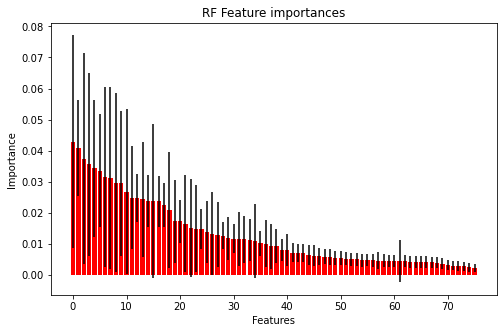

In [16]:
# Plot the feature importances of the forest
plt.figure(figsize=(8,5))
plt.title("RF Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

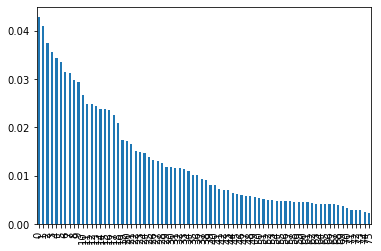

In [11]:
important_df['Importance'].plot(kind='bar')

<BarContainer object of 76 artists>

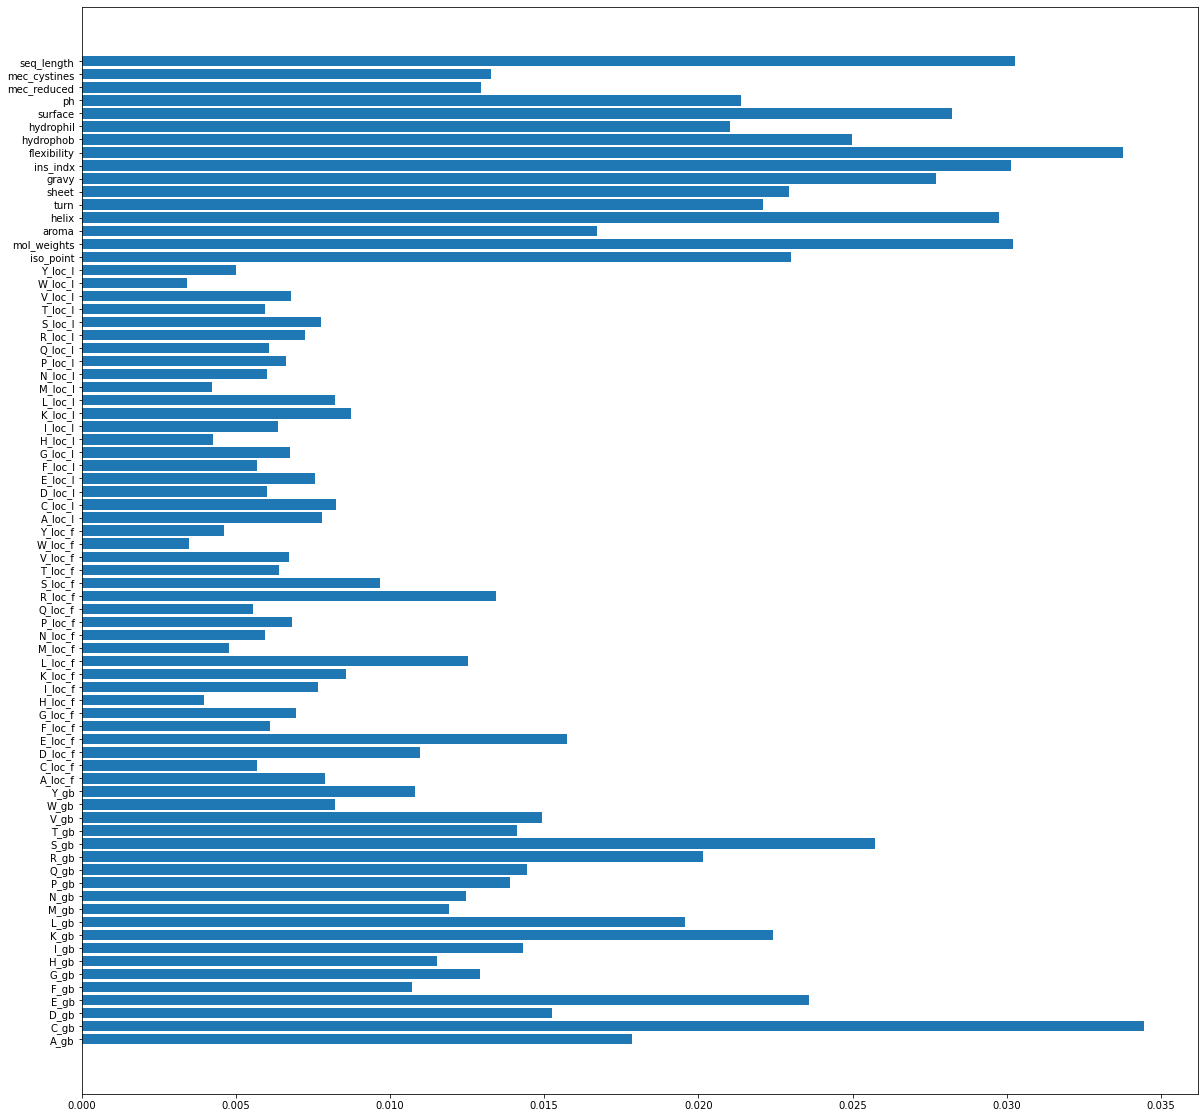

In [75]:

plt.figure(figsize=(20, 20))
plt.barh(X.columns.values, rf.feature_importances_)

Text(0.5, 0, 'Random Forest Feature Importance')

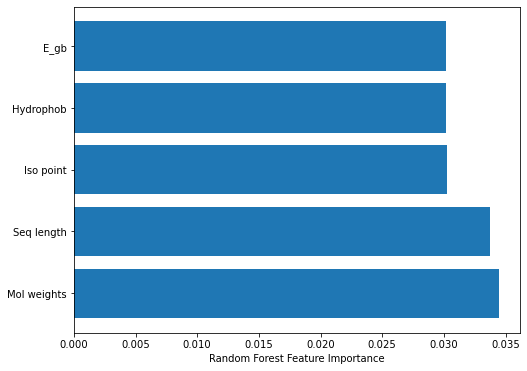

In [104]:
plt.figure(figsize=(8, 6))
sorted_idx = rf.feature_importances_.argsort()
plt.barh(np.array(['Mol weights','Seq length','Iso point','Hydrophob','E_gb']), rf.feature_importances_[sorted_idx][:-6:-1])
plt.xlabel("Random Forest Feature Importance")

### 3.3) Distribution plots for different features

Text(0, 0.5, 'Density')

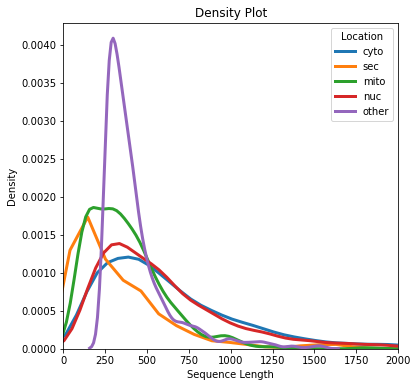

In [122]:
# 1) Sequence length

plt.figure(figsize=(6, 6))
# List of five airlines to plot
airlines = ['cyto', 'sec', 'mito','nuc','other']

# Iterate through the five airlines
for airline in airlines:
    # Subset to the airline
    subset = X['seq_length'][(y == airline).tolist()]
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = airline)

# # Plot formatting
plt.xlim(0,2000)
plt.legend(prop={'size': 10}, title = 'Location')
plt.title('Density Plot')
plt.xlabel('Sequence Length')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

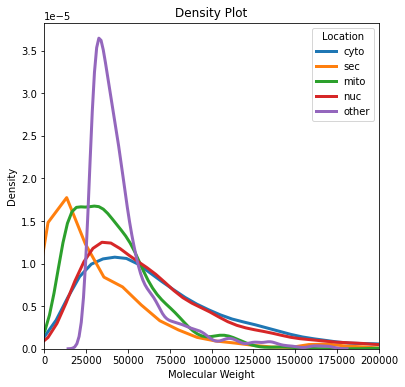

In [124]:
# 2) Molecular weight
plt.figure(figsize=(6, 6))
# List of five airlines to plot
airlines = ['cyto', 'sec', 'mito','nuc','other']

# Iterate through the five airlines
for airline in airlines:
    # Subset to the airline
    subset = X['mol_weights'][(y == airline).tolist()]
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = airline)

# # Plot formatting
plt.xlim(0,0.2e6)
plt.legend(prop={'size': 10}, title = 'Location')
plt.title('Density Plot')
plt.xlabel('Molecular Weight')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

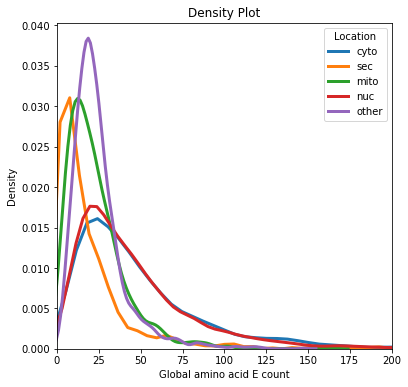

In [129]:
# 3) Global count E
plt.figure(figsize=(6, 6))
# List of five airlines to plot
airlines = ['cyto', 'sec', 'mito','nuc','other']

# Iterate through the five airlines
for airline in airlines:
    # Subset to the airline
    subset = X['E_gb'][(y == airline).tolist()]
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = airline)

# # Plot formatting
plt.xlim(0,200)
plt.legend(prop={'size': 10}, title = 'Location')
plt.title('Density Plot')
plt.xlabel('Global amino acid E count')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

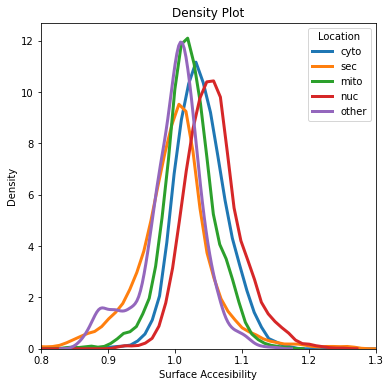

In [132]:
# 4) Surface

plt.figure(figsize=(6, 6))
# List of five airlines to plot
airlines = ['cyto', 'sec', 'mito','nuc','other']

# Iterate through the five airlines
for airline in airlines:
    # Subset to the airline
    subset = X['surface'][(y == airline).tolist()]
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = airline)

# # Plot formatting
plt.xlim(0.8,1.3)
plt.legend(prop={'size': 10}, title = 'Location')
plt.title('Density Plot')
plt.xlabel('Surface Accesibility')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

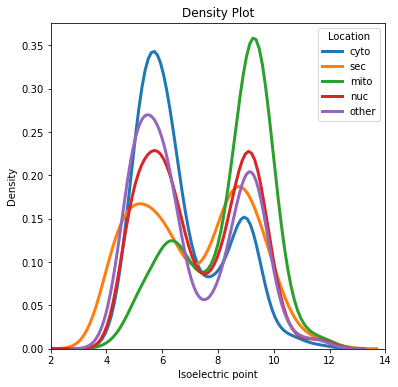

In [275]:
# 4) Isoelectric point

plt.figure(figsize=(6, 6))
# List of five airlines to plot
airlines = ['cyto', 'sec', 'mito','nuc','other']

# Iterate through the five airlines
for airline in airlines:
    # Subset to the airline
    subset = X['iso_point'][(y == airline).tolist()]
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = airline)

# # Plot formatting
plt.xlim(2,14)
plt.legend(prop={'size': 10}, title = 'Location')
plt.title('Density Plot')
plt.xlabel('Isoelectric point')
plt.ylabel('Density')

#### 3.4) PCA

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# scaling X's
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# X_blind = scaler.transform(X_blind)

# transforming y's

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

X_train.shape, X_test.shape, X_blind.shape
np.bincount(y_train), np.bincount(y_test)

(array([2394, 1015, 2679, 1602, 1289], dtype=int64),
 array([610, 284, 635, 400, 316], dtype=int64))

In [4]:
X_train.shape

(8979, 76)

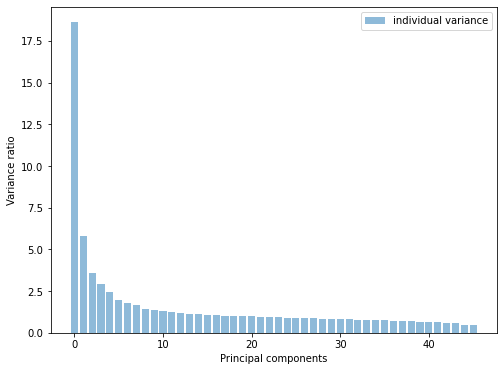

In [10]:
pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
# X_blind_pca = pca.transform(X_blind)

pca_variance = pca.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(range(X_train_pca.shape[1]), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

In [12]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)
# X_blind_pca = pca.transform(X_blind)

# pca_variance = pca.explained_variance_

# plt.figure(figsize=(8, 6))
# plt.bar(range(X_train_pca.shape[1]), pca_variance, alpha=0.5, align='center', label='individual variance')
# plt.legend()
# plt.ylabel('Variance ratio')
# plt.xlabel('Principal components')
# plt.show()

In [19]:
res = pd.DataFrame(X_train_pca[:,0], columns=['PC1'])
res['PC2'] = X_train_pca[:,1]
res['Y'] = y_train
res.shape, res.head()

((8979, 3),
         PC1       PC2  Y
 0  1.666863  1.562192  2
 1  0.789060  2.665363  0
 2 -0.466877  5.094671  4
 3  1.167130 -0.898637  0
 4  4.328701  1.358296  0)

### 4) Model selection

In [152]:
def blind_seq(clf, X_blind_pca):
    test_labels = clf.predict(X_blind_pca)
    test_labels = le.inverse_transform(test_labels)
    predprobs = clf.predict_proba(X_blind_pca)
    confidence_df = pd.DataFrame(predprobs)
    confidence = confidence_df.max(axis=1)
    final_output = pd.DataFrame()
    final_output['Seq'] = b_idx
    final_output['prediction'] = test_labels
    final_output['measure'] = 'Confidence'
    final_output['confidence'] = (confidence*100).round(1).astype(str) + '%'
    return final_output, predprobs

#### 4.1) Clustering based classifier

In [ ]:
# KNN
k = [20,40,60,80]
cv_k_acc = np.zeros(len(k))
knn_f1 = np.zeros(len(k))
for i in range(len(k)):
    clf1 = KNeighborsClassifier(n_neighbors=k[i])
    clf1.fit(X_train, y_train)
    y_pred_lr = clf1.predict(X_test)
    print('KNN Accuracy =', round(metrics.accuracy_score(y_test, y_pred_lr),3),'F1 score = ', round(metrics.f1_score(y_test, y_pred_lr, average='weighted'),3))
#     print('F1 score', metrics.f1_score(y_test, y_pred_lr, average='weighted'))
    cv_k_acc[i] = metrics.accuracy_score(y_test, y_pred_lr)
    knn_f1[i] = metrics.f1_score(y_test, y_pred_lr, average='weighted')
    
best_i = np.argmax(cv_k_acc)
print('Best k = ',k[best_i])
clf1 = KNeighborsClassifier(n_neighbors=k[best_i])
clf1.fit(X_train, y_train)
y_pred_lr = clf1.predict(X_test)
print('KNN Accuracy =', round(metrics.accuracy_score(y_test, y_pred_lr),3),'F1 score = ', round(metrics.f1_score(y_test, y_pred_lr, average='weighted'),3))
knn_best_acc = round(metrics.accuracy_score(y_test, y_pred_lr),3)
knn_df, pred_probs = blind_seq(clf1, X_blind)

#### 4.2) Tree based method

In [167]:
# Gradient Boosting Classifier
estimators = [250,500,750]
cv_gb_acc = np.zeros(len(estimators))
for i in range(len(estimators)):
    clf2 = GradientBoostingClassifier(n_estimators=estimators[i])
    clf2.fit(X_train, y_train)
    y_pred_lr = clf2.predict(X_test)
    print('Gradient Boost Accuracy =', round(metrics.accuracy_score(y_test, y_pred_lr),3),'F1 score = ', round(metrics.f1_score(y_test, y_pred_lr, average='weighted'),3))
    cv_gb_acc[i] = metrics.accuracy_score(y_test, y_pred_lr)
    

best_i = np.argmax(cv_gb_acc)
print('Best estimator = ', estimators[best_i])
clf2 = GradientBoostingClassifier(n_estimators=estimators[best_i])
clf2.fit(X_train, y_train)
y_pred_lr = clf2.predict(X_test)
print('Gradient Boost Accuracy =', round(metrics.accuracy_score(y_test, y_pred_lr),3),'F1 score = ', round(metrics.f1_score(y_test, y_pred_lr, average='weighted'),3))


gb_df, pred_probs = blind_seq(clf2, X_blind)

Gradient Boost Accuracy = 0.675 F1 score =  0.674
Gradient Boost Accuracy = 0.678 F1 score =  0.677
Gradient Boost Accuracy = 0.686 F1 score =  0.687
Best estimator =  750
Gradient Boost Accuracy = 0.686 F1 score =  0.687


,Seq,prediction,measure,confidence
0,SEQ01,other,Confidence,99.9%
1,SEQ02,mito,Confidence,88.3%
2,SEQ03,mito,Confidence,91.8%
3,SEQ04,cyto,Confidence,60.2%
4,SEQ05,cyto,Confidence,71.9%
5,SEQ06,mito,Confidence,94.9%
6,SEQ07,sec,Confidence,97.4%
7,SEQ08,mito,Confidence,73.3%
8,SEQ09,sec,Confidence,73.6%
9,SEQ10,mito,Confidence,61.5%


#### 4.3) SVM Classifier

In [168]:
C = [25,50,75,100,150,200]
cv_svm_acc = np.zeros(len(C))

for i in range(len(C)):
    clf3 = SVC(probability=True,C=C[i])
    clf3.fit(X_train, y_train)
    y_pred_lr = clf3.predict(X_test)
    print('SVC Accuracy =', round(metrics.accuracy_score(y_test, y_pred_lr),3),'F1 score = ', round(metrics.f1_score(y_test, y_pred_lr, average='weighted'),3))
    cv_svm_acc[i] = metrics.accuracy_score(y_test, y_pred_lr)
    

best_i = np.argmax(cv_svm_acc)
print('Best estimator = ', C[best_i])

clf3 = SVC(probability=True,C=C[best_i])
clf3.fit(X_train, y_train)
y_pred_lr = clf3.predict(X_test)
print('SVC Accuracy =', round(metrics.accuracy_score(y_test, y_pred_lr),3),'F1 score = ', round(metrics.f1_score(y_test, y_pred_lr, average='weighted'),3))

svm_df, pred_probs = blind_seq(clf3, X_blind)

SVC Accuracy = 0.643 F1 score =  0.645
SVC Accuracy = 0.635 F1 score =  0.636
SVC Accuracy = 0.634 F1 score =  0.635
SVC Accuracy = 0.635 F1 score =  0.636
SVC Accuracy = 0.637 F1 score =  0.638
SVC Accuracy = 0.636 F1 score =  0.637
Best estimator =  25
SVC Accuracy = 0.643 F1 score =  0.645


,Seq,prediction,measure,confidence
0,SEQ01,other,Confidence,91.6%
1,SEQ02,mito,Confidence,62.2%
2,SEQ03,mito,Confidence,63.2%
3,SEQ04,cyto,Confidence,48.7%
4,SEQ05,cyto,Confidence,72.3%
5,SEQ06,mito,Confidence,88.1%
6,SEQ07,sec,Confidence,95.3%
7,SEQ08,mito,Confidence,50.9%
8,SEQ09,sec,Confidence,94.2%
9,SEQ10,cyto,Confidence,40.3%


In [169]:
#### 4.4) Non-linear classifiers

# Neural network
n = [100, 150]
alphas = [0.01, 0.05, 0.1]
activation = ['relu','tanh','logistic']
cv_nn_errors = np.zeros((len(n),len(alphas),len(activation)))
for i in range(len(n)):
    for j in range(len(alphas)):
        for k in range(len(activation)):
            clf4 = MLPClassifier(hidden_layer_sizes=n[i],activation=activation[k],
                                 solver='adam',alpha=alphas[j], max_iter=500)
            clf4.fit(X_train, y_train)
            y_pred_lr = clf4.predict(X_test)
            print('NN Accuracy =', round(metrics.accuracy_score(y_test, y_pred_lr),3),'F1 score = ', round(metrics.f1_score(y_test, y_pred_lr, average='weighted'),3))
            cv_nn_errors[i][j][k] = metrics.accuracy_score(y_test, y_pred_lr)

best_i, best_j, best_k = np.where(cv_nn_errors == np.max(cv_nn_errors))
print('Best estimator => n =', n[best_i],' , alpha = ',alphas[best_j],' , activation = ',activation[best_k])
clf4 = MLPClassifier(hidden_layer_sizes=n[best_i[0]],activation=activation[best_k[0]],
                                 solver='adam',alpha=alphas[best_j[0]])
clf4.fit(X_train, y_train)
y_pred_lr = clf4.predict(X_test)
print('NN Accuracy =', round(metrics.accuracy_score(y_test, y_pred_lr),3),'F1 score = ', round(metrics.f1_score(y_test, y_pred_lr, average='weighted'),3))


nn_df, pred_probs = blind_seq(clf4, X_blind)
nn_df

NN Accuracy = 0.612 F1 score =  0.611
NN Accuracy = 0.581 F1 score =  0.581


C:\Users\Akshaya\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


NN Accuracy = 0.624 F1 score =  0.624


C:\Users\Akshaya\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


NN Accuracy = 0.623 F1 score =  0.622
NN Accuracy = 0.596 F1 score =  0.597


C:\Users\Akshaya\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


NN Accuracy = 0.625 F1 score =  0.625
NN Accuracy = 0.632 F1 score =  0.631
NN Accuracy = 0.601 F1 score =  0.603


C:\Users\Akshaya\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


NN Accuracy = 0.653 F1 score =  0.651
NN Accuracy = 0.627 F1 score =  0.626
NN Accuracy = 0.606 F1 score =  0.606


C:\Users\Akshaya\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


NN Accuracy = 0.621 F1 score =  0.62
NN Accuracy = 0.636 F1 score =  0.635
NN Accuracy = 0.609 F1 score =  0.61


C:\Users\Akshaya\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


NN Accuracy = 0.653 F1 score =  0.653
NN Accuracy = 0.629 F1 score =  0.629
NN Accuracy = 0.597 F1 score =  0.597


C:\Users\Akshaya\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


NN Accuracy = 0.651 F1 score =  0.65
NN Accuracy = 0.673 F1 score =  0.671


C:\Users\Akshaya\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Seq,prediction,measure,confidence
0,SEQ01,other,Confidence,98.1%
1,SEQ02,mito,Confidence,61.4%
2,SEQ03,mito,Confidence,78.0%
3,SEQ04,cyto,Confidence,58.5%
4,SEQ05,cyto,Confidence,53.0%
5,SEQ06,mito,Confidence,86.8%
6,SEQ07,sec,Confidence,92.6%
7,SEQ08,mito,Confidence,72.1%
8,SEQ09,sec,Confidence,74.6%
9,SEQ10,mito,Confidence,65.4%


In [171]:
print('Best estimator => n =', n[best_i[0]],' , alpha = ',alphas[best_j[0]],' , activation = ',activation[best_k[0]])

Best estimator => n = 100  , alpha =  0.1  , activation =  logistic


Text(0.5, 1.0, 'Max Accuracy for each method')

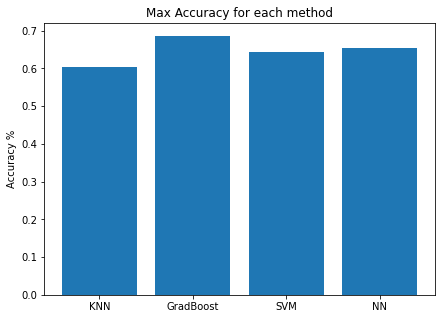

In [220]:
plt.figure(figsize=(7,5))
methods = ['KNN','GradBoost','SVM','NN']
scores = [round(max(cv_k_acc),3), round(max(cv_gb_acc),3), round(max(cv_svm_acc),3), round(np.max(cv_nn_errors),3)]
plt.bar(methods,scores)
plt.ylabel('Accuracy %')
plt.title('Max Accuracy for each method')

# plt.barh(methods,scores)
# plt.tight_layout()
# for index, value in enumerate(scores):
#     plt.text(value, index ,str(value))
    


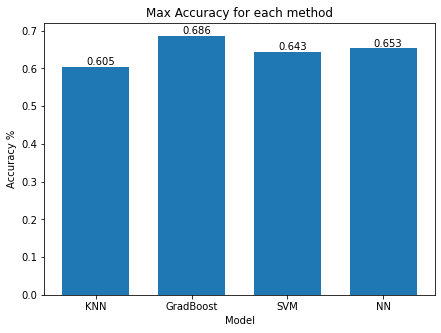

In [236]:
i = 1.0
j = 0.0055
plt.figure(figsize=(7,5))
plt.bar(methods,scores,align='center',width=0.7)
for i in range(len(scores)):
    plt.annotate(scores[i], (-0.1 + i, scores[i] + j))
    
plt.xlabel('Model')
plt.ylabel('Accuracy %')
plt.title('Max Accuracy for each method')
plt.show()

In [24]:
# one vs all approach
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

clf = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=750))
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)
print('F1 score: ',metrics.f1_score(y_test, pred, average='micro'))
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    roc_auc = metrics.auc(fpr[i], tpr[i])
    print(roc_auc)

F1 score:  0.6824053452115812
0.8187266255577279
0.9272090985484556
0.8698850687142368
0.9731436314363143
0.9590625430635668


In [25]:
print('F1 score: ',metrics.f1_score(y_test, pred, average='macro'))
print('F1 score: ',metrics.f1_score(y_test, pred, average='weighted'))

F1 score:  0.7036373992641781
F1 score:  0.6813439868526601


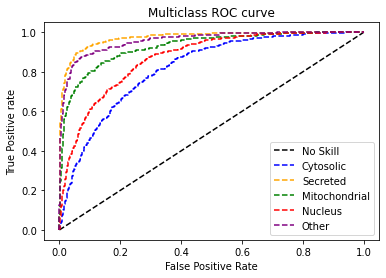

In [185]:
plt.plot([0, 1], [0, 1], 'k--', label = 'No Skill')
plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='Cytosolic')
plt.plot(fpr[3], tpr[3], linestyle='--',color='orange', label='Secreted')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Mitochondrial')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label='Nucleus')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Other')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300)

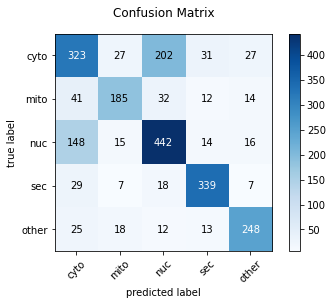

In [188]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
multiclass = confusion_matrix(y_test, pred)
class_names = ['cyto', 'mito', 'nuc', 'sec','other']

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=False,
                                class_names=class_names)
plt.title('Confusion Matrix')
plt.show()